# [GD-2] SentencePiece 
## 멋진 단어사전 만들기
### 목차
   

#### 1. 들어가며
  1-1. SentencePiece          
 
#### 2. 프로젝트
  2-1. 프로젝트 진행 흐름              
  2-2. 데이터셋 설명          
  2-3. 데이터 준비 및 확인          
  2-4. SentencePiece 모델 학습          
  2-5. Tokenizer 함수 작성          
  2-6. LSTM으로 감정분석 모델 학습          
  2-7. 모델 성능 비교 평가          
  2-8. 학습 과정 평가          

#### 3. 회고
  3-1. 최종 정리          
  3-2. 느낀점           
  3-3. 에러 & 경고          
  3-4. 참고사이트          

### 루브릭 평가 기준
|평가문항|상세기준|
|:---|:---|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|   
<br/>

----


## 1. 들어가며
### 1-1. SentencePiece
* 내부 단어 분리를 위한 유용한 패키지
* Google이 BPE 알고리즘과 Unigram Language Model Tokenizer를 구현한 센텐스피스를 깃허브에 공개
* **센텐스피스는 사전 토큰화 작업없이 단어 분리 토큰화를 수행하므로 언어에 종속되지 않음!**

* 논문 : https://arxiv.org/pdf/1808.06226.pdf        
* 센텐스피스 깃허브 : https://github.com/google/sentencepiece        



## 2. 프로젝트
#### 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기
링크 : https://github.com/e9t/nsmc/

### 2-1. 프로젝트 진행 흐름
* 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
* 학습된 모델로 sp_tokenize() 메소드 구현하기
* 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
* KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
* (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

### 2-2. 데이터셋 설명
#### Data Description
* Each file is consisted of three columns: id, document, label
  * id: The review id, provieded by Naver
  * document: The actual review
  * label: The sentiment class of the review. (0: negative, 1: positive)
  * Columns are delimited with tabs (i.e., .tsv format; but the file extension is .txt for easy access for novices)
* 200K reviews in total
  * ratings.txt: All 200K reviews
  * ratings_test.txt: 50K reviews held out for testing
  * ratings_train.txt: 150K reviews for training
  
#### Characteristics
* All reviews are shorter than 140 characters
* Each sentiment class is sampled equally (i.e., random guess yields 50% accuracy)
  * 100K negative reviews (originally reviews of ratings 1-4)
  * 100K positive reviews (originally reviews of ratings 9-10)
  * Neutral reviews (originally reviews of ratings 5-8) are excluded

### 2-3. 데이터 준비 및 확인
#### 필요한 라이브러리 import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy
import pandas as pd

import os
import urllib.request

from tensorflow import keras

print(tf.__version__)
print(np.__version__)
# print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.22.2
0.5.2


#### 네이버 영화 리뷰 데이터 가져오기

In [2]:
data_file_path = os.getenv('HOME') + '/aiffel/GoingDeeper/GD_2/naver/ratings.txt'

data = pd.read_csv(data_file_path, sep='\t', engine='python', encoding = 'UTF8')

data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


#### 데이터 정보 살펴보기

In [3]:
before_data = len(data)
print('데이터 수 :', before_data)

데이터 수 : 200000


#### 데이터에 NULL 값이 남아있는지 확인하기

In [4]:
print(data.isnull().sum())

id          0
document    8
label       0
dtype: int64


#### Null 값 제거

In [5]:
data.dropna(axis=0, inplace=True)
print('전체 데이터 수 :', (len(data)))

전체 데이터 수 : 199992


#### 중복 데이터 확인

In [6]:
print('document 열에서 중복된 데이터 수 :', len(data) - data['document'].nunique())

document 열에서 중복된 데이터 수 : 5449


#### 데이터프레임의 drop_duplicates( ) 함수를 이용해서 중복 샘플 제거

In [7]:
cleaned_corpus = data.drop_duplicates(subset = ['document'])
print('전체 데이터 수 :', (len(data)))

전체 데이터 수 : 199992


#### 최종 데이터 정보 확인

In [8]:
print('전처리 전 데이터 개수 :', before_data)
print('전처리 후 데이터 개수 :', len(cleaned_corpus)) 

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 194543


In [9]:
cleaned_corpus.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [10]:
review = cleaned_corpus['document']

In [11]:
review

0                                       어릴때보고 지금다시봐도 재밌어요ㅋㅋ
1         디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...
2                      폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
3         와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...
4                               안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.
                                ...                        
199995                                       포켓 몬스터 짜가 ㅡㅡ;;
199996                                                쓰.레.기
199997                    완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.
199998                  왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ
199999                                      포풍저그가나가신다영차영차영차
Name: document, Length: 194543, dtype: object

#### 문장 길이에 대한 데이터 시각화

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_3017/4172591407.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


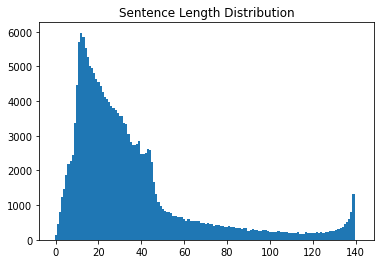

In [12]:
min_len = 999
max_len = 0
sum_len = 0

for sen in review:
    length = len(sen)
    if min_len > length: min_len = length    
    if max_len < length: max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(review))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [13]:
sentence_length

array([ 124,  460,  793, 1222, 1469, 1882, 2187, 2270, 2440, 3379, 4459,
       5711, 5970, 5848, 5518, 5265, 5005, 4947, 4806, 4626, 4542, 4436,
       4264, 4129, 4073, 3973, 3865, 3809, 3743, 3665, 3561, 3566, 3353,
       3339, 3036, 2831, 2736, 2736, 2775, 2856, 2486, 2486, 2495, 2625,
       2599, 2257, 1660, 1311, 1079,  968,  893,  844,  799,  789,  765,
        678,  686,  654,  658,  648,  614,  554,  600,  555,  544,  554,
        528,  528,  473,  493,  443,  477,  469,  443,  403,  437,  422,
        388,  398,  365,  372,  398,  380,  381,  326,  350,  327,  308,
        333,  332,  260,  286,  300,  281,  291,  255,  261,  271,  283,
        246,  231,  233,  223,  224,  244,  221,  223,  216,  211,  198,
        185,  206,  199,  215,  177,  178,  178,  219,  198,  199,  195,
        183,  221,  192,  226,  194,  218,  218,  247,  245,  252,  276,
        304,  350,  380,  452,  514,  589,  802, 1328,    0,    1])

#### 문장 길이가 '1'인 문장 확인

In [14]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(review, 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


#### 문장 길이가 '142'인 문장 확인

In [15]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(review, 140)

초반엔 황당한 설정이다 싶어 몰입이 힘들었지만 점차 이건 판타지가 아니라 우리의 근미래에 현실이 될지도 모르는 언론탄압에 대한 진지한 은유라는 생각이 들었다. 남자주인공 오카다 준이치는 예상보다 훨씬 좋았다. 별 기대없이 보았는데 의외의 재미와 감동.
개인적으로 재미있었습니다. 언제 팬텀이랑 크리스틴이랑 그런일이 있었는지 전혀 몰랐네요.... ㅠㅠㅠ 일반스토리들 처럼 크리스틴이 다시 남편 곁으로 돌아갔었더라면하는 아쉬움은 있네요 The Beauty Underneath가 젤 좋았어요 개인적으로 ㅋㅋㅋ
그냥 뮤직비디오 본다고 생각하면 훌륭한 작품이다. 동양인 비하라고 하는 분들에게 몇마디하자면 이 영화 자체가 디스를 통한 개그코드를 유지합니다. 남녀 비하, 유태인, 레즈비언, 오타쿠들 등등 동양인도 그소재중 하나지 동양비하가 본 목적은 아니에요 ㅋㅋ
나의 평점은 9점인데, 평균평점이 8점이라 10점으로 주겠다. 오페라 몇편을 감상한듯 전율이 이는 사운드와 자유를 갈망하는 민중의 패기 어린 웅장함이 가슴을 울렸다. 살짝 아쉬운 느낌이 들지만, 한편에 긴 대서사시를 이렇게 옮긴것만 해도 극찬받을만하다
선유야 사랑해 우리 좀있다가 보자!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!
진짜 평점주러 오는건 처음이다.2년전 영화를 지금 본게 너무 후회스럽다ㅜ진짜 주연배우들이 정말 너무 매력있고 스토리가 너무 잼있다.진짜 어제보고 오늘 또 본 영화는 처음이다.연애하고싶게만드는 영화였고 명대사들이 너무 좋은 영화였다@연애하기좋을날씨다~@
진실평점 8점이상 9점을 준건 평점을 끌어올기위해 10점은 너무 말이 안됨 그렇다고 7점대를 돌아다닐 영화가 아님 헐리웃을 개량하면서 유사한 영화들도 8점대는 다넘는데 이 영화가 못넘다니 조금 웃기고 불편한진실 너훈아가 나훈아만큼의 인기를 누린만큼이다
안개 속에서 균형을 잃고

#### 적절한 최대 문장 길이 찾기


In [16]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %.2f'%(max_len, (cnt / len(nested_list))*100))

In [17]:
below_threshold_len(36, review)  # 평균
below_threshold_len(140, review)  # 최장 
below_threshold_len(70, review)  # 중앙값

below_threshold_len(60, review)  
below_threshold_len(50, review)  

전체 샘플 중 길이가 36 이하인 샘플의 비율: 66.09
전체 샘플 중 길이가 140 이하인 샘플의 비율: 100.00
전체 샘플 중 길이가 70 이하인 샘플의 비율: 88.67
전체 샘플 중 길이가 60 이하인 샘플의 비율: 85.87
전체 샘플 중 길이가 50 이하인 샘플의 비율: 82.06


/tmp/ipykernel_3017/1803270478.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


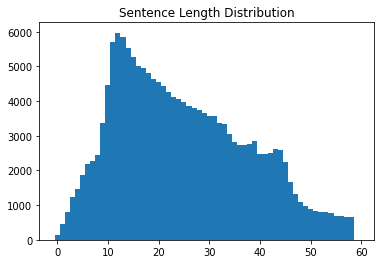

In [18]:
max_len = 60   
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len)]

# 1. 내가 짰지만 비효율적인 코드 
filtered_corpus = [] 
filtered_label = []  
for row, label in zip(data['document'], data['label']):    
    if (len(row) < max_len):     
        filtered_corpus.append(row)  
        filtered_label.append(label)   
        
# 2. 같이 공부하는 @수희님이 알려주신 코드 
# 데이터프레임 조건부 슬라이싱 
# str.len() 두 함수에 대해 알 수 있었다. 
train_data = cleaned_corpus[cleaned_corpus['document'].str.len() < max_len]   



# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [19]:
sentence_length

array([ 124,  460,  793, 1222, 1469, 1882, 2187, 2270, 2440, 3379, 4459,
       5711, 5970, 5848, 5518, 5265, 5005, 4947, 4806, 4626, 4542, 4436,
       4264, 4129, 4073, 3973, 3865, 3809, 3743, 3665, 3561, 3566, 3353,
       3339, 3036, 2831, 2736, 2736, 2775, 2856, 2486, 2486, 2495, 2625,
       2599, 2257, 1660, 1311, 1079,  968,  893,  844,  799,  789,  765,
        678,  686,  654,  658,    0])

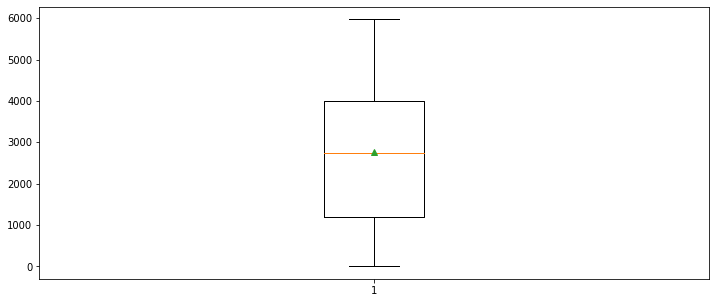

In [20]:
plt.figure(figsize=(12,5))
plt.boxplot([sentence_length], showmeans=True)
plt.show()

In [21]:
print('전처리 전 데이터 개수 :', len(data))
print('전처리 후 데이터 개수 :', len(train_data))
print('전처리 후 남은 데이터 양(%)', (len(train_data)/len(data))*100)

전처리 전 데이터 개수 : 199992
전처리 후 데이터 개수 : 166401
전처리 후 남은 데이터 양(%) 83.20382815312612


### 2-4. SentencePiece 모델 학습

In [22]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/GoingDeeper/GD_2/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_unigram --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

# --model_type 변경
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe --vocab_size={}'.format(temp_file, vocab_size)    
)


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/GoingDeeper/GD_2/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm_unigram --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/GoingDeeper/GD_2/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm_unigram
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0

In [23]:
!ls -l korean_spm_unigram*
!ls -l korean_spm_bpe*


trainer_interface.cc(487) LOG(INFO) Alphabet size=1755
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.9995
trainer_interface.cc(520) LOG(INFO) Done! preprocessed 171835 sentences.
unigram_model_trainer.cc(139) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(143) LOG(INFO) Extracting frequent sub strings...
unigram_model_trainer.cc(194) LOG(INFO) Initialized 259223 seed sentencepieces
trainer_interface.cc(526) LOG(INFO) Tokenizing input sentences with whitespace: 171835
trainer_interface.cc(537) LOG(INFO) Done! 299023
unigram_model_trainer.cc(489) LOG(INFO) Using 299023 sentences for EM training
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=133235 obj=15.2697 num_tokens=704052 num_tokens/piece=5.28429
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=123573 obj=14.2003 num_tokens=708524 num_tokens/piece=5.73365
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=92627 obj=14.3034 num_tokens=738333 num_tokens/piece=7.97103
unigram_m

-rw-r--r-- 1 root root 375187 Mar 23 12:36 korean_spm_unigram.model
-rw-r--r-- 1 root root 144497 Mar 23 12:36 korean_spm_unigram.vocab
-rw-r--r-- 1 root root 375183 Mar 23 12:37 korean_spm_bpe.model
-rw-r--r-- 1 root root 144497 Mar 23 12:37 korean_spm_bpe.vocab


#### SentencePiece의 토크나이징 결과 확인

In [24]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [25]:
print('korean_spm_unigram')
print('---------------------------------------')
test_performance(model='korean_spm_unigram.model')
print('=======================================')

print('korean_spm_bpe')
print('---------------------------------------')
test_performance(model='korean_spm_bpe.model')
print('=======================================')

korean_spm_unigram
---------------------------------------
[1661, 9, 467, 16, 1396, 9, 161, 15, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
korean_spm_bpe
---------------------------------------
[1661, 9, 467, 16, 1396, 9, 161, 15, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### 2-5. Tokenizer 함수 작성
* ```sp_tokenize()``` 함수     
  1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.     
  2) 생성된 vocab 파일을 읽어와 ```{ <word> : <idx> }``` 형태를 가지는 word_index 사전과 ```{ <idx> : <word>}``` 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.     
  3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding 적용     

In [26]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [27]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()
s.Load('korean_spm_unigram.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'korean_spm_unigram')           
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  491 3265
    14 1101 2624    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1593 2183  227  547    9
   311 7921  799    8]]


### 2-6. LSTM으로 감정분석 모델 학습

In [28]:
tensor, word_index, index_word = sp_tokenize(s, train_data['document'], 'korean_spm_unigram')

In [29]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(train_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [30]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

106496 26624 33281
106496 26624 33281


In [31]:
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,
                                    ))
            
model_LSTM.add(keras.layers.LSTM(128))
# model_LSTM.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [32]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [33]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=es,
                    verbose=1)

Epoch 1/20
1664/1664 [==============================] - 213s 127ms/step - loss: 0.4077 - accuracy: 0.8119 - val_loss: 0.3554 - val_accuracy: 0.8451
Epoch 2/20
1664/1664 [==============================] - 211s 127ms/step - loss: 0.3222 - accuracy: 0.8603 - val_loss: 0.3351 - val_accuracy: 0.8529
Epoch 3/20
1664/1664 [==============================] - 213s 128ms/step - loss: 0.2853 - accuracy: 0.8768 - val_loss: 0.3411 - val_accuracy: 0.8534
Epoch 4/20
1664/1664 [==============================] - 211s 127ms/step - loss: 0.2528 - accuracy: 0.8923 - val_loss: 0.3523 - val_accuracy: 0.8535
Epoch 5/20
1664/1664 [==============================] - 210s 126ms/step - loss: 0.2234 - accuracy: 0.9060 - val_loss: 0.3607 - val_accuracy: 0.8505
Epoch 6/20
1664/1664 [==============================] - 211s 127ms/step - loss: 0.1941 - accuracy: 0.9202 - val_loss: 0.3999 - val_accuracy: 0.8452
Epoch 00006: early stopping


In [34]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
print(results)

832/832 - 23s - loss: 0.4068 - accuracy: 0.8427
[0.40684688091278076, 0.842698335647583]


#### bpe

In [35]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'korean_spm_bpe')           
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  491 3265
    14 1101 2624    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1593 2183  227  547    9
   311 7921  799    8]]


In [36]:
tensor, word_index, index_word = sp_tokenize(s, train_data['document'], 'korean_spm_bpe')

In [37]:
filtered_label = np.array(train_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [38]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

106496 26624 33281
106496 26624 33281


In [39]:

vocab_size = vocab_size
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,
                                    ))
            
model_LSTM.add(keras.layers.LSTM(128))
# model_LSTM.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [40]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [41]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=es,
                    verbose=1)

Epoch 1/20
1664/1664 [==============================] - 214s 128ms/step - loss: 0.4032 - accuracy: 0.8164 - val_loss: 0.3512 - val_accuracy: 0.8468
Epoch 2/20
1664/1664 [==============================] - 214s 129ms/step - loss: 0.3200 - accuracy: 0.8611 - val_loss: 0.3376 - val_accuracy: 0.8526
Epoch 3/20
1664/1664 [==============================] - 215s 129ms/step - loss: 0.2846 - accuracy: 0.8768 - val_loss: 0.3422 - val_accuracy: 0.8538
Epoch 4/20
1664/1664 [==============================] - 215s 129ms/step - loss: 0.2542 - accuracy: 0.8900 - val_loss: 0.3559 - val_accuracy: 0.8497
Epoch 5/20
1664/1664 [==============================] - 222s 133ms/step - loss: 0.2260 - accuracy: 0.9040 - val_loss: 0.3779 - val_accuracy: 0.8478
Epoch 6/20
1664/1664 [==============================] - 225s 135ms/step - loss: 0.1976 - accuracy: 0.9173 - val_loss: 0.4104 - val_accuracy: 0.8417
Epoch 00006: early stopping


In [42]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
print(results)

832/832 - 25s - loss: 0.4124 - accuracy: 0.8421
[0.4123634696006775, 0.8421348929405212]


### 2-7. 모델 성능 비교 평가


In [43]:
def performance_test_spm(spm_model, vocab_size, word_vector_dim):
    s = spm.SentencePieceProcessor()
    s.Load("{}.model".format(spm_model)) 
    
    tensor, word_index, index_word = sp_tokenize(s, train_data['document'], spm_model)
    
    x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    

    model_LSTM = keras.Sequential()
    model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                     word_vector_dim,
                                        ))

    model_LSTM.add(keras.layers.LSTM(128))
    model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model_LSTM.summary()
    
    model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
    epochs=10
    batch_size=64
        
    history_LSTM = model_LSTM.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val,y_val),
                        callbacks=[es],
                        verbose=1)
    
    results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
    print(results)
    
    return history_LSTM

In [44]:
history_unigram_dim_8 = performance_test_spm('korean_spm_unigram', vocab_size, word_vector_dim=8)
history_bpe_dim_8 = performance_test_spm('korean_spm_bpe', vocab_size, word_vector_dim=8)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1664/1664 [==============================] - 207s 123ms/step - loss: 0.4162 - accuracy: 0.8061 - val_loss: 0.3605 - val_accuracy: 0.8427
Epoch 2/10
1664/1664 [==============================] - 200s 120ms/step - loss: 0.3330 - accuracy: 0.8568 - val_loss: 0.3473 - val_accuracy: 0.8465
Epoch 3/10
1664/1664 [==============================] - 201s 121ms/step - loss: 0.

### 2-8. 학습 과정 평가

In [45]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

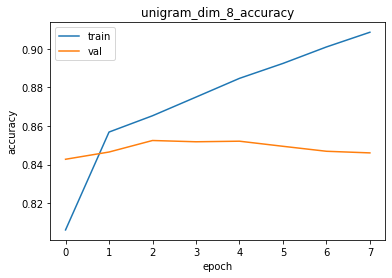

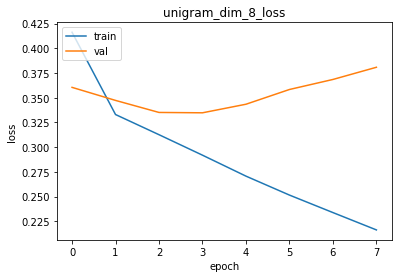

In [46]:
visualize_train(history_unigram_dim_8, param='unigram_dim_8')

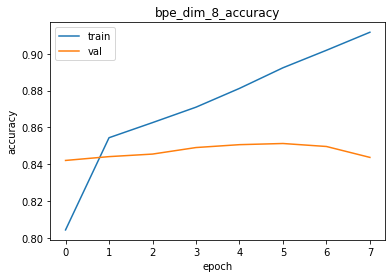

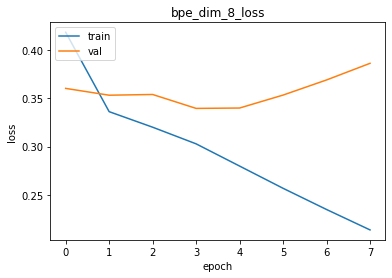

In [47]:
visualize_train(history_bpe_dim_8, param='bpe_dim_8')

## 3. 회고

### 3-1. 최종 정리
* Unigram 결과   
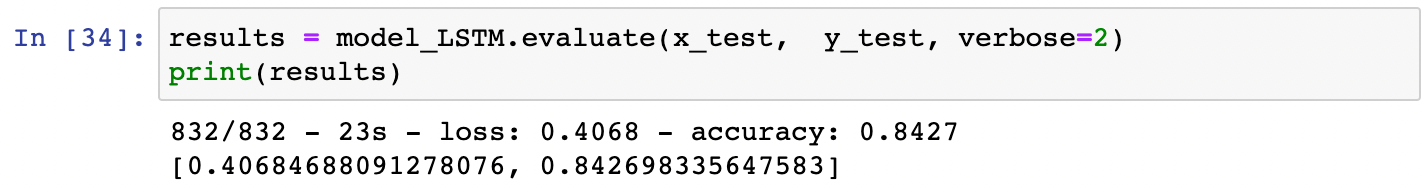


* BPE 결과    
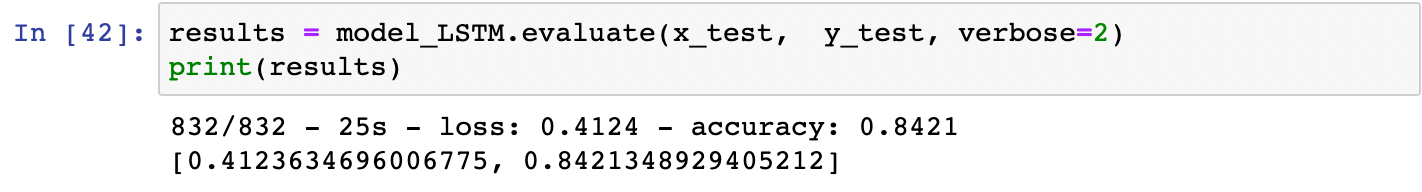


**두 결과의 큰 차이가 없었다.** 

<br/>
<br/>

### 3-2. 느낀점 
* 영화 리뷰 데이터셋에 대해 다시 한번 제대로 살펴볼 수 있었다는 것과 이전 Exploration 을 복습할 수 있어서 의미있었다.    
* 내용이 이해가 안되는 부분이 있어 이미 프로젝트를 진행한 다른 분 코드를 참고했는데 아직 내용을 잘 모르지 뭐가 맞고 뭐가 틀린지, 어떤걸 가져와야 내게 의미있는 코드인지를 정확히 알기 어려웠다. 
* 그래도 첫 Going Deeper 프로젝트인만큼 잘 끝마친 것에 다행이라 생각하고.. 앞으로는 프로젝트 이후에도 열심히 복습해야겠다. 
<br/>
<br/>


### 3-3. 에러 & 경고
* matplotlib 의 버전 확인 후, .pyplot 붙임
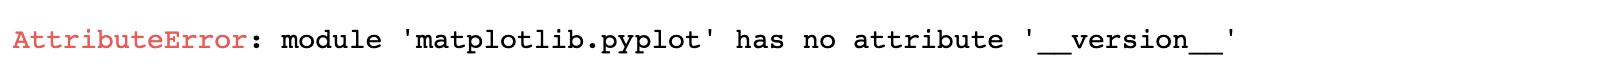


* Numpy 버전 관련 경고메시지
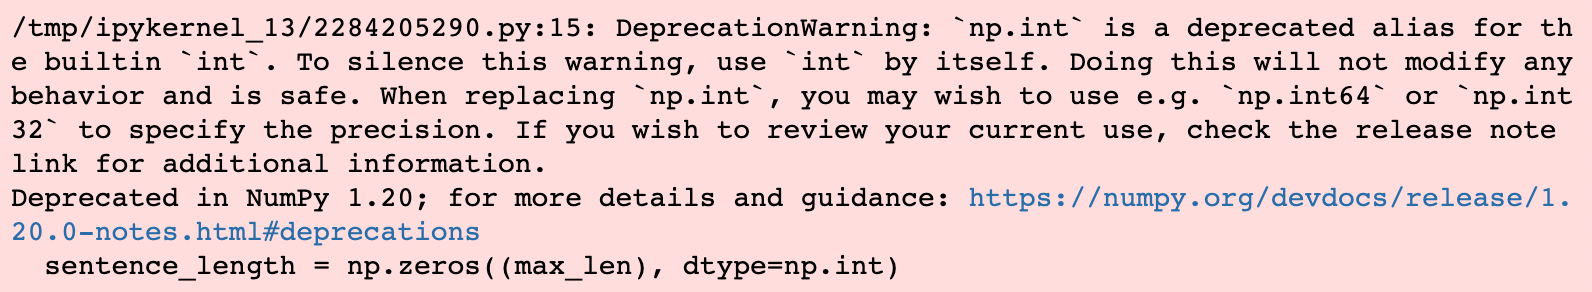


* 한글 인코딩 관련으로 UTF-8 로 변경해서 해결
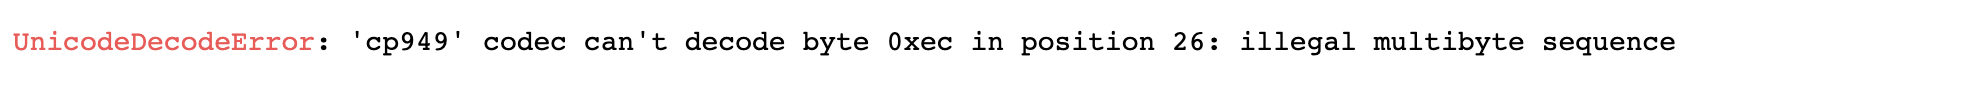

<br/>
<br/>


### 3-4. 참고사이트
* 딥 러닝을 이용한 자연어 처리 입문 : 센텐스피스     
  https://wikidocs.net/86657     
  
  
* 이전 Exploration 06 & 08
  https://github.com/Sujin530/AIFFEL_project/blob/main/Exploration%2006/%5BE_06%5DMovieReviewSentimentAnalysis.ipynb   
  https://github.com/Sujin530/AIFFEL_project/blob/main/Exploration%2008/%5BE_08%5DNewsSummarization.ipynb   



* 중앙값 구하기    
  https://codingdojang.com/scode/611?langby=python  



* Gihub    
  https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-02%5DSentencePiece.ipynb
  
  
* Numpy 경고 메시지       
  https://koobh.tistory.com/51      
  
  
* cp949 에러 메시지     
  https://studyforus.tistory.com/167
  